In [49]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stockda/BND_historical_data.csv
/kaggle/input/stockda/SPY_historical_data.csv
/kaggle/input/stockdata/BND_historical_data.csv
/kaggle/input/stockdata/SPY_historical_data.csv
/kaggle/input/tsladata/TSLA_historical_data.csv


In [50]:
!pip install convertdate

In [51]:
!pip install pmdarima

In [52]:
!pip install prophet

In [53]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from math import sqrt
import matplotlib.pyplot as plt

class TimeSeriesForecaster:
    def __init__(self, csv_path, date_column="Date", target_column="Close"):
        self.data = pd.read_csv(csv_path, parse_dates=[date_column])
        self.data.set_index(date_column, inplace=True)
        self.target_column = target_column
        self.train = None
        self.test = None

    def train_test_split(self, train_size=0.8):
        split_idx = int(train_size * len(self.data))
        self.train = self.data.iloc[:split_idx]
        self.test = self.data.iloc[split_idx:]

    def train_arima(self, order=(1, 1, 1)):
        arima_model = ARIMA(self.train[self.target_column], order=order).fit()
        arima_forecast = arima_model.forecast(steps=len(self.test))  # Match forecast length with test set
        arima_rmse = sqrt(mean_squared_error(self.test[self.target_column], arima_forecast))
        arima_mape = mean_absolute_percentage_error(self.test[self.target_column], arima_forecast)
        return arima_forecast, arima_rmse, arima_mape

    def train_exponential_smoothing(self, seasonal_periods=12):
        es_model = ExponentialSmoothing(
            self.train[self.target_column], trend='add', seasonal='add', seasonal_periods=seasonal_periods
        ).fit()
        es_forecast = es_model.forecast(steps=len(self.test))
        es_rmse = sqrt(mean_squared_error(self.test[self.target_column], es_forecast))
        es_mape = mean_absolute_percentage_error(self.test[self.target_column], es_forecast)
        return es_forecast, es_rmse, es_mape

    def train_prophet(self):
        # Reset index and rename columns
        prophet_df = self.train.reset_index().rename(columns={self.train.index.name: 'ds', self.target_column: 'y'})
        
        # Remove timezone if it exists
        prophet_df['ds'] = prophet_df['ds'].dt.tz_localize(None)  # Remove timezone if any
        
        # Instantiate and fit the Prophet model
        prophet_model = Prophet()
        prophet_model.fit(prophet_df)
        
        # Create future dataframe for forecasting
        prophet_future = prophet_model.make_future_dataframe(periods=len(self.test), freq='D')
        
        # Make predictions
        prophet_forecast = prophet_model.predict(prophet_future)
        
        # Calculate RMSE and MAPE
        prophet_rmse = sqrt(mean_squared_error(self.test[self.target_column], prophet_forecast['yhat'][-len(self.test):]))
        prophet_mape = mean_absolute_percentage_error(self.test[self.target_column], prophet_forecast['yhat'][-len(self.test):])
        
        return prophet_forecast['yhat'][-len(self.test):], prophet_rmse, prophet_mape

    def evaluate_models(self):
        # Split data
        self.train_test_split()
    
        # Run models
        arima_forecast, arima_rmse, arima_mape = self.train_arima()
        es_forecast, es_rmse, es_mape = self.train_exponential_smoothing()
        prophet_forecast, prophet_rmse, prophet_mape = self.train_prophet()
    
        # Print evaluation metrics
        print("ARIMA RMSE:", arima_rmse, "| MAPE:", arima_mape)
        print("Exponential Smoothing RMSE:", es_rmse, "| MAPE:", es_mape)
        print("Prophet RMSE:", prophet_rmse, "| MAPE:", prophet_mape)
    
        # Create the plot
        plt.figure(figsize=(14, 8))
    
        # Plot the train and test data
        plt.plot(self.train.index, self.train[self.target_column], label='Train Data', color='black', linewidth=2)
        plt.plot(self.test.index, self.test[self.target_column], label='Test Data', color='blue', linestyle='--', linewidth=2)
    
        # Plot the forecasts from different models
        plt.plot(self.test.index, arima_forecast, label=f'ARIMA Forecast (RMSE: {arima_rmse:.2f}, MAPE: {arima_mape:.2f})', color='#1f77b4', linewidth=2)
        plt.plot(self.test.index, es_forecast, label=f'Exponential Smoothing (RMSE: {es_rmse:.2f}, MAPE: {es_mape:.2f})', color='#ff7f0e', linewidth=2)
        plt.plot(self.test.index, prophet_forecast, label=f'Prophet Forecast (RMSE: {prophet_rmse:.2f}, MAPE: {prophet_mape:.2f})', color='#2ca02c', linewidth=2)
    
        # Add grid lines
        plt.grid(True, linestyle='--', alpha=0.7)
    
        # Customize the title and labels
        plt.title('Time Series Model Comparison_TSLA', fontsize=18, fontweight='bold')
        plt.xlabel('Date', fontsize=14)
        plt.ylabel(self.target_column, fontsize=14)
    
        # Customize legend
        plt.legend(loc='upper left', fontsize=12, frameon=False, title='Model Performance', title_fontsize=14)
    
        # Save the figure to a file (high resolution for better quality in presentations)
        plt.savefig('/kaggle/working/forecast_comparison_TSLA.png', dpi=300, bbox_inches='tight')
    
        # Show the plot
        plt.show()

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/conda/lib/p

ARIMA RMSE: 42.57601741053566 | MAPE: 0.16201486580678742
Exponential Smoothing RMSE: 37.295084106455626 | MAPE: 0.15932281971671544
Prophet RMSE: 113.02812198901053 | MAPE: 0.56319946402076


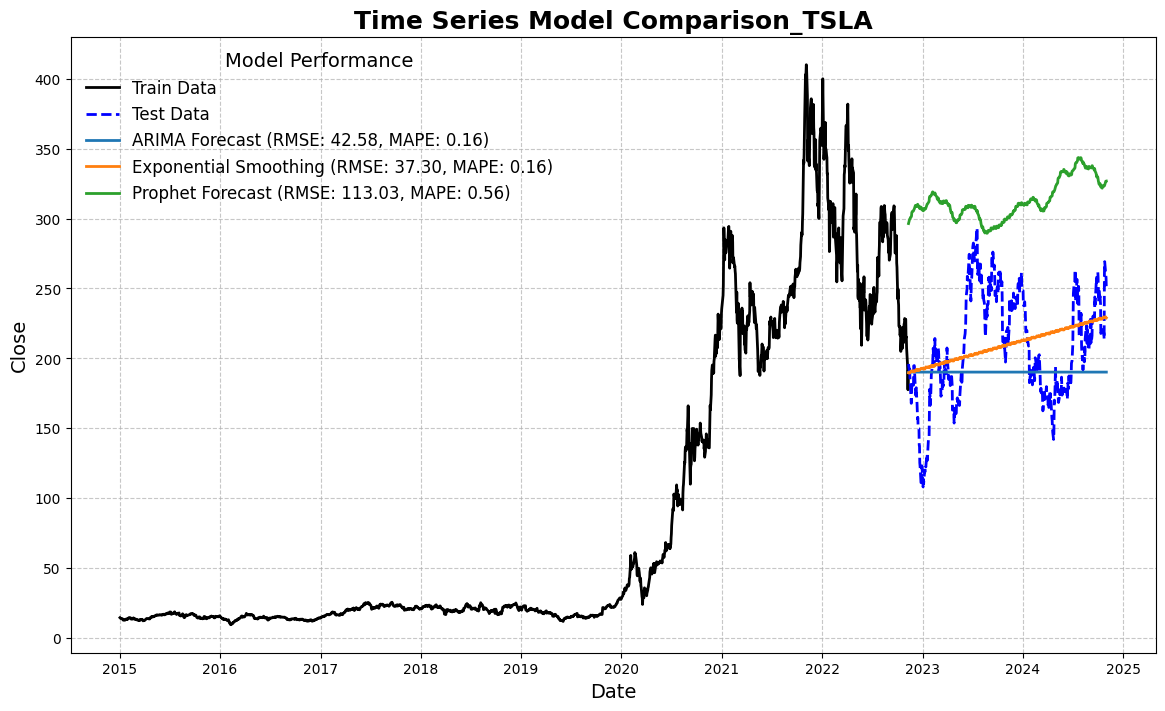

In [54]:
# Instantiate the TimeSeriesForecaster class with your CSV file
forecaster = TimeSeriesForecaster(csv_path="/kaggle/input/tsladata/TSLA_historical_data.csv", date_column="Date", target_column="Close")

# Call the evaluate_models method to get forecasts and evaluation metrics
forecaster.evaluate_models()

In [55]:
from pmdarima import auto_arima
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

class TimeSeriesForecasteroptimal:
    
    def __init__(self, csv_path, date_column, target_column):
        # Initialize the forecaster with the dataset path and target column
        self.csv_path = csv_path
        self.date_column = date_column
        self.target_column = target_column
        self.data = pd.read_csv(csv_path, parse_dates=[date_column])
        self.data.set_index(date_column, inplace=True)
        
        self.train = None
        self.test = None

    def train_test_split(self, test_size=0.2):
        # Split the data into train and test sets
        n = len(self.data)
        train_size = int(n * (1 - test_size))
        self.train, self.test = self.data[:train_size], self.data[train_size:]

    def find_best_arima(self):
        # Find the best ARIMA model using auto_arima
        model = auto_arima(self.train[self.target_column], seasonal=False, stepwise=True, trace=True)
        return model

    def evaluate_best_arima(self):
        # Ensure data is split
        self.train_test_split()

        # Find the best ARIMA model
        best_arima_model = self.find_best_arima()
        
        # Forecast using the best ARIMA model
        arima_forecast = best_arima_model.predict(n_periods=len(self.test))
        
        # Calculate RMSE and MAPE for the forecast
        arima_rmse = np.sqrt(mean_squared_error(self.test[self.target_column], arima_forecast))
        arima_mape = mean_absolute_percentage_error(self.test[self.target_column], arima_forecast)
        
        # Return forecast and metrics
        return arima_forecast, arima_rmse, arima_mape
    
    def evaluate_grid_search_arima(self):
        # Perform grid search for ARIMA hyperparameters using auto_arima
        model = auto_arima(self.train[self.target_column], seasonal=False, stepwise=True, trace=True)
        
        # Forecast using the best model
        grid_forecast = model.predict(n_periods=len(self.test))
    
        # Calculate RMSE and MAPE
        grid_rmse = np.sqrt(mean_squared_error(self.test[self.target_column], grid_forecast))
        grid_mape = mean_absolute_percentage_error(self.test[self.target_column], grid_forecast)
    
        # Get the best ARIMA parameters
        best_params = model.get_params()
    
        # Print the return values to check
        print(f"grid_forecast: {grid_forecast}")
        print(f"grid_rmse: {grid_rmse}")
        print(f"grid_mape: {grid_mape}")
        print(f"best_params: {best_params}")
    
        # Return the forecast, RMSE, MAPE, and best ARIMA parameters
        return grid_forecast, grid_rmse, grid_mape, best_params
    def evaluate_models(self):
        # Split data
        self.train_test_split()
    
        # Run models
        arima_forecast, arima_rmse, arima_mape = self.train_arima()
        es_forecast, es_rmse, es_mape = self.train_exponential_smoothing()
        prophet_forecast, prophet_rmse, prophet_mape = self.train_prophet()
    
        # Print evaluation metrics
        print("ARIMA RMSE:", arima_rmse, "| MAPE:", arima_mape)
        print("Exponential Smoothing RMSE:", es_rmse, "| MAPE:", es_mape)
        print("Prophet RMSE:", prophet_rmse, "| MAPE:", prophet_mape)
    
        # Create the plot
        plt.figure(figsize=(14, 8))
    
        # Plot the train and test data
        plt.plot(self.train.index, self.train[self.target_column], label='Train Data', color='black', linewidth=2)
        plt.plot(self.test.index, self.test[self.target_column], label='Test Data', color='blue', linestyle='--', linewidth=2)
    
        # Plot the forecasts from different models
        plt.plot(self.test.index, arima_forecast, label=f'ARIMA Forecast (RMSE: {arima_rmse:.2f}, MAPE: {arima_mape:.2f})', color='#1f77b4', linewidth=2)
        plt.plot(self.test.index, es_forecast, label=f'Exponential Smoothing (RMSE: {es_rmse:.2f}, MAPE: {es_mape:.2f})', color='#ff7f0e', linewidth=2)
        plt.plot(self.test.index, prophet_forecast, label=f'Prophet Forecast (RMSE: {prophet_rmse:.2f}, MAPE: {prophet_mape:.2f})', color='#2ca02c', linewidth=2)
    
        # Add grid lines
        plt.grid(True, linestyle='--', alpha=0.7)
    
        # Customize the title and labels
        plt.title('Time Series Model Comparison_TSLA', fontsize=18, fontweight='bold')
        plt.xlabel('Date', fontsize=14)
        plt.ylabel(self.target_column, fontsize=14)
    
        # Customize legend
        plt.legend(loc='upper left', fontsize=12, frameon=False, title='Model Performance', title_fontsize=14)
    
        # Save the figure to a file (high resolution for better quality in presentations)
        plt.savefig('/kaggle/working/forecast_comparison_OPTIMAL_TSLA.png', dpi=300, bbox_inches='tight')
    
        # Show the plot
        plt.show()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=12355.548, Time=1.44 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12351.803, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12350.296, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12350.407, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12350.325, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=12351.817, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12351.550, Time=0.37 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=12353.550, Time=0.56 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=12348.860, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=12350.364, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=12350.101, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=12348.972, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=12352.101, Time=0.32 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 3.575 seconds
Best ARIM

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=12355.548, Time=0.97 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12351.803, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12350.296, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12350.407, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12350.325, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=12351.817, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12351.550, Time=0.37 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=12353.550, Time=0.56 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=12348.860, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=12350.364, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=12350.101, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=12348.972, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=12352.101, Time=0.33 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 3.099 seconds
grid_forecast: 1980    190.170230
1981    190.193249

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


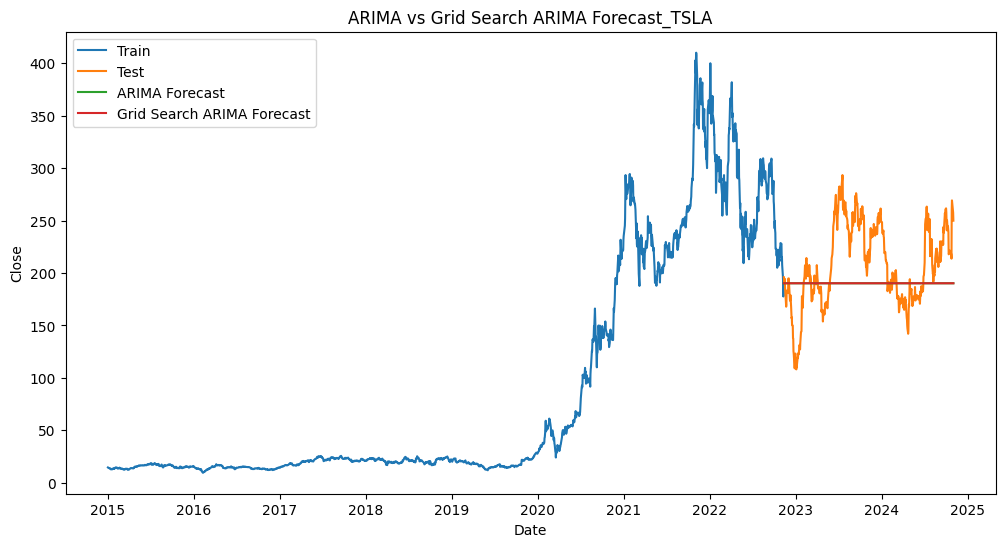

In [56]:
# Example usage
forecaster = TimeSeriesForecasteroptimal(csv_path="/kaggle/input/tsladata/TSLA_historical_data.csv", date_column="Date", target_column="Close")

# Evaluate Best ARIMA
arima_forecast, arima_rmse, arima_mape = forecaster.evaluate_best_arima()
print("Best ARIMA RMSE:", arima_rmse, "| MAPE:", arima_mape)

# Evaluate ARIMA with Grid Search
grid_forecast, grid_rmse, grid_mape, best_params = forecaster.evaluate_grid_search_arima()
print("Grid Search ARIMA RMSE:", grid_rmse, "| MAPE:", grid_mape)
print("Best ARIMA Parameters (p, d, q):", best_params)

# Plot the forecasts
plt.figure(figsize=(12, 6))
plt.plot(forecaster.train.index, forecaster.train[forecaster.target_column], label='Train')
plt.plot(forecaster.test.index, forecaster.test[forecaster.target_column], label='Test')
plt.plot(forecaster.test.index, arima_forecast, label='ARIMA Forecast')
plt.plot(forecaster.test.index, grid_forecast, label='Grid Search ARIMA Forecast')
plt.legend(loc='upper left')
plt.title('ARIMA vs Grid Search ARIMA Forecast_TSLA')
plt.xlabel('Date')
plt.ylabel(forecaster.target_column)
# Save the figure to a file (high resolution for better quality in presentations)
plt.savefig('/kaggle/working/forecast_comparison_optimal_TSLA.png', dpi=300, bbox_inches='tight')
    
plt.show()
